In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn')
%matplotlib inline 

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [3]:
confirmed_df.iloc[88:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
88,NaN,Bulgaria,42.7339,25.4858,0,0,0,0,0,0,...,23,41,51,52,67,92,94,127,163,187
89,NaN,Maldives,3.2028,73.2207,0,0,0,0,0,0,...,9,10,13,13,13,13,13,13,13,13
90,NaN,Bangladesh,23.6850,90.3563,0,0,0,0,0,0,...,3,3,5,8,10,14,17,20,25,27
91,NaN,Paraguay,-23.4425,-58.4438,0,0,0,0,0,0,...,6,6,6,8,9,11,11,13,18,22
92,Ontario,Canada,51.2538,-85.3232,0,0,0,0,1,1,...,74,79,104,177,185,221,257,308,377,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,NaN,Dominica,15.4150,-61.3710,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
483,NaN,Grenada,12.1165,-61.6790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
484,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
485,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20'],
      dtype='object')

In [5]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]
dates = confirmed.iloc[:,49:].keys()

In [6]:
dates

Index(['3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20',
       '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20'],
      dtype='object')

In [7]:
days_since_3_11 = np.array([i for i in range(len(dates))]).reshape(-1, 1)

In [8]:
#dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 
bd_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    bd_cases.append(confirmed_df[confirmed_df['Country/Region']=='Bangladesh'][i].sum())

In [9]:
#days_since__22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [10]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [11]:
start = '3/11/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [12]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_3_11, world_cases, test_size=0.15, shuffle=False) 

In [13]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed.ravel())
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 145752.86672494892
MSE: 21490873924.289085


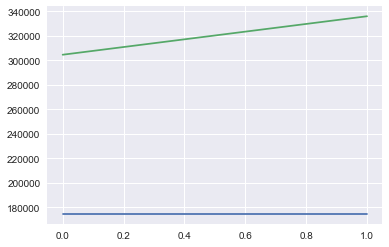

In [14]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [15]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [16]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 21888.587878765073
MSE: 675440478.8863258


In [17]:
print(linear_model.coef_)

[[ 1.25500076e+05 -3.96795364e+03  1.11850038e+04 -3.11369062e+03
   3.71336305e+02 -1.50734615e+01]]


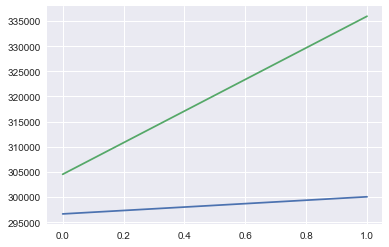

In [18]:
plt.plot(test_linear_pred)
plt.plot(y_test_confirmed)

In [19]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('03/23/2020', 174487.0),
 ('03/24/2020', 174487.0),
 ('03/25/2020', 174487.0),
 ('03/26/2020', 174488.0),
 ('03/27/2020', 174488.0),
 ('03/28/2020', 174489.0),
 ('03/29/2020', 174490.0),
 ('03/30/2020', 174491.0),
 ('03/31/2020', 174493.0),
 ('04/01/2020', 174495.0)}

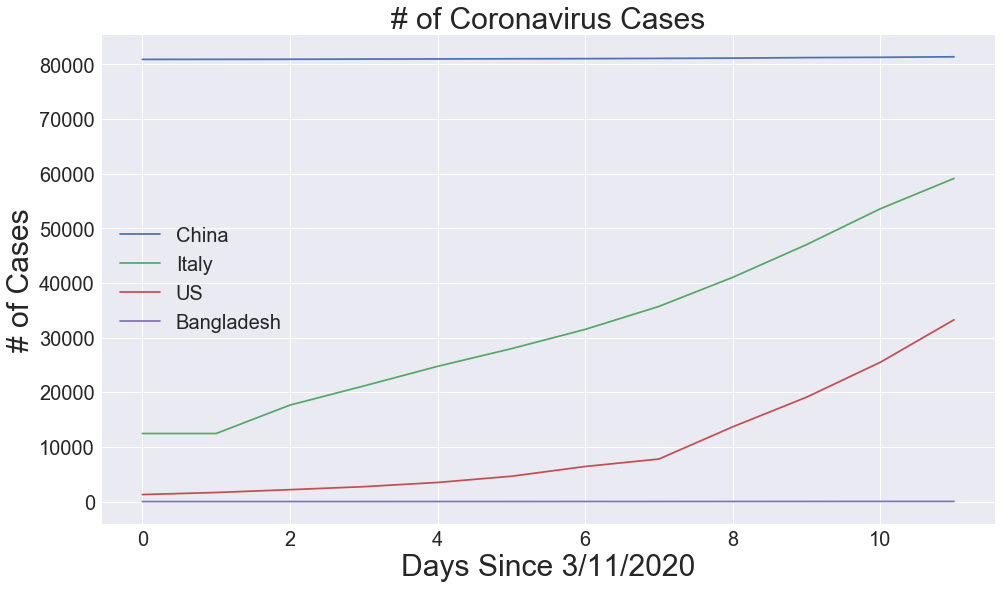

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, bd_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 3/11/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US','Bangladesh'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()